## Load Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import importlib
import xgboost as xgb
from tqdm import tqdm
from collections import defaultdict
from model_utils import *
from ModelInfo import ModelInfo
import traceback
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import all_estimators
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## Chargement des modèles sklearn

L'objectif étant de comparer les performances de différents modèles, nous proposons une approche comparant tous les modèles régressif de la bibliothèque scikit-learn, ainsi que d'autres modèles souvent utilisés pour de tâches de régression (ex: xgboost). \
/!\ La comparaison de ces modèles n'a de sens que si l'on comprend le fonctionnement interne de chacun des modèles de la librairie. \
L'approche exploratoire proposée ici est un challenge ajouté au projet. Nous ne retiendrons que les résultats des modèles les plus connus pour répondre à la problématique.

### 1. Récupération des modèles régression de sklearn - classement par groupes custom

In [2]:
all_estimators_list = all_estimators(type_filter='regressor')

# catégories customisées pour les modèles
model_categories = {
    "Linear Models": [],
    "Tree-based Models": [],
    "Ensemble Methods": [],
    "Bayesian Models": [],
    "Support Vector Machines": [],
    "K-Nearest Neighbors": [],
    "Neural Networks": [],
    "Others": []
}

# Classement des modèles par catégorie
for name, EstimatorClass in all_estimators_list:
    try:
        model_instance = EstimatorClass()
        model_description = EstimatorClass.__doc__.split("\n")[0] if EstimatorClass.__doc__ else "No description"
    except TypeError:
        model_description = "Requires additional arguments"

    # Classification par catégorie
    if issubclass(EstimatorClass, LinearRegression):
        model_categories["Linear Models"].append((name, model_description))
    elif issubclass(EstimatorClass, DecisionTreeRegressor):
        model_categories["Tree-based Models"].append((name, model_description))
    elif issubclass(EstimatorClass, RandomForestRegressor):
        model_categories["Ensemble Methods"].append((name, model_description))
    elif 'Bayes' in name:
        model_categories["Bayesian Models"].append((name, model_description))
    elif 'SVR' in name:
        model_categories["Support Vector Machines"].append((name, model_description))
    elif 'KNeighbors' in name:
        model_categories["K-Nearest Neighbors"].append((name, model_description))
    elif 'MLP' in name:
        model_categories["Neural Networks"].append((name, model_description))
    else:
        model_categories["Others"].append((name, model_description))

# Afficher les modèles et leurs descriptions
for category, models in model_categories.items():
    print(f"\n{category}:")
    for model_name, description in models:
        print(f" - {model_name}: {description}")



Linear Models:
 - LinearRegression: 

Tree-based Models:
 - DecisionTreeRegressor: A decision tree regressor.
 - ExtraTreeRegressor: An extremely randomized tree regressor.

Ensemble Methods:
 - RandomForestRegressor: 

Bayesian Models:
 - BayesianRidge: Bayesian ridge regression.

Support Vector Machines:
 - LinearSVR: Linear Support Vector Regression.
 - NuSVR: Nu Support Vector Regression.
 - SVR: Epsilon-Support Vector Regression.

K-Nearest Neighbors:
 - KNeighborsRegressor: Regression based on k-nearest neighbors.

Neural Networks:
 - MLPRegressor: Multi-layer Perceptron regressor.

Others:
 - ARDRegression: Bayesian ARD regression.
 - AdaBoostRegressor: An AdaBoost regressor.
 - BaggingRegressor: A Bagging regressor.
 - CCA: Canonical Correlation Analysis, also known as "Mode B" PLS.
 - DummyRegressor: Regressor that makes predictions using simple rules.
 - ElasticNet: Linear regression with combined L1 and L2 priors as regularizer.
 - ElasticNetCV: Elastic Net model with itera

### 2. Récupération des modèles régression de sklearn - classement par modules sklearn

In [3]:
all_estimators_list = all_estimators(type_filter='regressor')
regressor_models_by_module = defaultdict(list)

for name, EstimatorClass in all_estimators_list:
    try:
        model_instance = EstimatorClass()
        model_description = EstimatorClass.__doc__.split("\n")[0] if EstimatorClass.__doc__ else "No description"
    except TypeError:
        # Si des arguments sont nécessaires et que l'initialisation échoue
        model_description = "Requires additional arguments"
    
    # Module sklearn du modèle
    module = EstimatorClass.__module__.split('.')[1]  # ex: 'linear_model', 'tree'
    regressor_models_by_module[module].append((name, EstimatorClass, model_description))


def print_regressor_models_by_module(models_by_module):
    for module, models in models_by_module.items():
        print(f"\nModule: {module}")
        for model_name, _, description in models:
            print(f" - {model_name}: {description}")

print_regressor_models_by_module(regressor_models_by_module)



Module: linear_model
 - ARDRegression: Bayesian ARD regression.
 - BayesianRidge: Bayesian ridge regression.
 - ElasticNet: Linear regression with combined L1 and L2 priors as regularizer.
 - ElasticNetCV: Elastic Net model with iterative fitting along a regularization path.
 - GammaRegressor: Generalized Linear Model with a Gamma distribution.
 - HuberRegressor: L2-regularized linear regression model that is robust to outliers.
 - Lars: Least Angle Regression model a.k.a. LAR.
 - LarsCV: Cross-validated Least Angle Regression model.
 - Lasso: Linear Model trained with L1 prior as regularizer (aka the Lasso).
 - LassoCV: Lasso linear model with iterative fitting along a regularization path.
 - LassoLars: Lasso model fit with Least Angle Regression a.k.a. Lars.
 - LassoLarsCV: Cross-validated Lasso, using the LARS algorithm.
 - LassoLarsIC: Lasso model fit with Lars using BIC or AIC for model selection.
 - LinearRegression: 
 - MultiTaskElasticNet: Multi-task ElasticNet model trained w

### 3. Test de séparation des modèles supportant le multi-output

In [4]:
# Jeu de données de régression avec plusieurs sorties (multi-output)
X, y = make_regression(n_samples=100, n_features=4, n_targets=2, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

all_estimators_list = all_estimators(type_filter='regressor')


regressor_models_by_module = defaultdict(list)
multioutput_models = defaultdict(list)
non_multioutput_models = defaultdict(list)


for name, EstimatorClass in all_estimators_list:
    try:
        model_instance = EstimatorClass()
        model_description = EstimatorClass.__doc__.split("\n")[0] if EstimatorClass.__doc__ else "No description"
        
        # Essayer d'entraîner le modèle sur des données multi-output
        model_instance.fit(X_train, y_train)
        # Si l'entraînement réussit, on considère que le modèle supporte le multi-output
        multioutput_models[EstimatorClass.__module__.split('.')[1]].append((name, EstimatorClass, model_description))
    except (TypeError, ValueError):
        # Si des arguments sont nécessaires ou si le modèle ne supporte pas le multi-output
        non_multioutput_models[EstimatorClass.__module__.split('.')[1]].append((name, EstimatorClass, model_description))
        continue


print("\n=== Models that natively support multi-output ===")
print_regressor_models_by_module(multioutput_models)

print("\n=== Models that do not support multi-output ===")
print_regressor_models_by_module(non_multioutput_models)



=== Models that natively support multi-output ===

Module: ensemble
 - BaggingRegressor: A Bagging regressor.
 - ExtraTreesRegressor: 
 - RandomForestRegressor: 

Module: cross_decomposition
 - CCA: Canonical Correlation Analysis, also known as "Mode B" PLS.
 - PLSCanonical: Partial Least Squares transformer and regressor.
 - PLSRegression: PLS regression.

Module: tree
 - DecisionTreeRegressor: A decision tree regressor.
 - ExtraTreeRegressor: An extremely randomized tree regressor.

Module: dummy
 - DummyRegressor: Regressor that makes predictions using simple rules.

Module: linear_model
 - ElasticNet: Linear regression with combined L1 and L2 priors as regularizer.
 - Lars: Least Angle Regression model a.k.a. LAR.
 - Lasso: Linear Model trained with L1 prior as regularizer (aka the Lasso).
 - LassoLars: Lasso model fit with Least Angle Regression a.k.a. Lars.
 - LinearRegression: 
 - MultiTaskElasticNet: Multi-task ElasticNet model trained with L1/L2 mixed-norm as regularizer.
 - 

### 4. Chargement des modèles sklearn + externes via la classe ModelInfo

In [5]:
# Utilisation de la classe ModelInfo avec un modèle externe comme XGBoost
external_models = [
    ('XGBRegressor', xgb.XGBRegressor)
]

model_info = ModelInfo(external_models=external_models)
model_info.fill_dataframe()

model_info.df_models

Filling DataFrame: 100%|██████████| 56/56 [00:00<00:00, 61.56it/s] 


,sk_learn_model,module,model_name,estimator,description,requires_additional_parameters,multi_output_native,multi_output
0,True,linear_model,ARDRegression,<class 'sklearn.linear_model._bayes.ARDRegress...,Bayesian ARD regression.,False,False,True
1,True,ensemble,AdaBoostRegressor,<class 'sklearn.ensemble._weight_boosting.AdaB...,An AdaBoost regressor.,False,False,True
2,True,ensemble,BaggingRegressor,<class 'sklearn.ensemble._bagging.BaggingRegre...,A Bagging regressor.,False,True,True
3,True,linear_model,BayesianRidge,<class 'sklearn.linear_model._bayes.BayesianRi...,Bayesian ridge regression.,False,False,True
4,True,cross_decomposition,CCA,<class 'sklearn.cross_decomposition._pls.CCA'>,"Canonical Correlation Analysis, also known as ...",False,True,True
5,True,tree,DecisionTreeRegressor,<class 'sklearn.tree._classes.DecisionTreeRegr...,A decision tree regressor.,False,True,True
6,True,dummy,DummyRegressor,<class 'sklearn.dummy.DummyRegressor'>,Regressor that makes predictions using simple ...,False,True,True
7,True,linear_model,ElasticNet,<class 'sklearn.linear_model._coordinate_desce...,Linear regression with combined L1 and L2 prio...,False,True,True
8,True,linear_model,ElasticNetCV,<class 'sklearn.linear_model._coordinate_desce...,Elastic Net model with iterative fitting along...,False,False,True
9,True,tree,ExtraTreeRegressor,<class 'sklearn.tree._classes.ExtraTreeRegress...,An extremely randomized tree regressor.,False,True,True


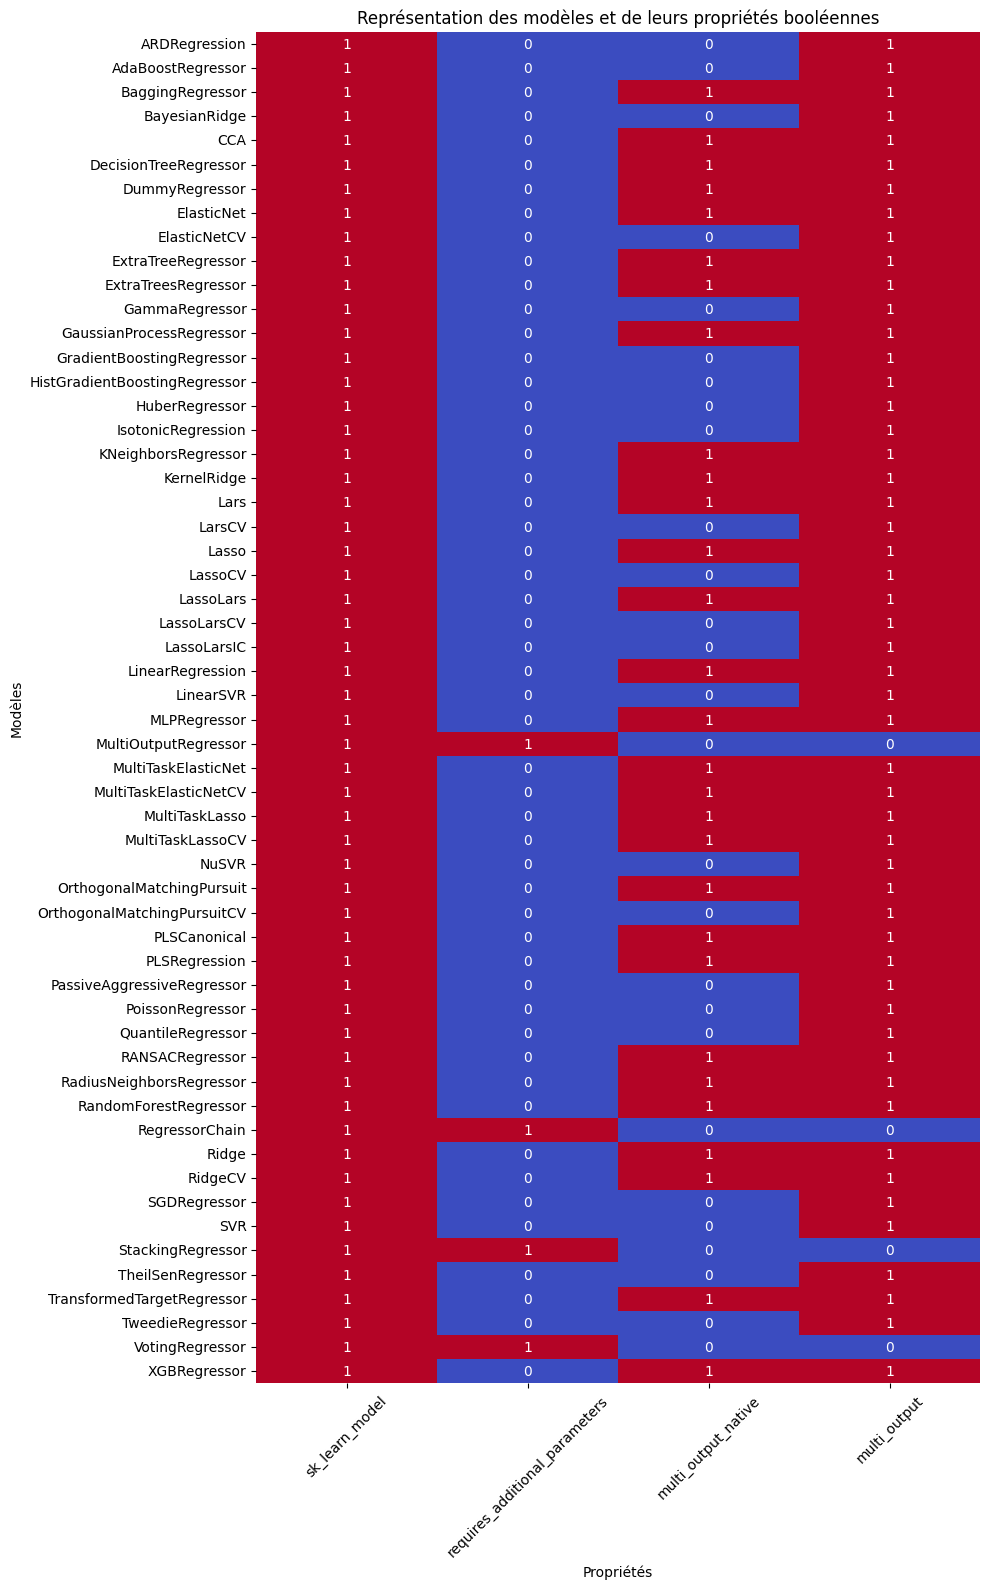

In [6]:
data = model_info.df_models.to_dict('records')

df_models = pd.DataFrame(data)

# Sélectionner uniquement les colonnes booléennes
bool_columns = df_models.select_dtypes(include=[bool])

# Créer une heatmap
plt.figure(figsize=(10, 16))
sns.heatmap(bool_columns, annot=True, cmap='coolwarm', cbar=False, yticklabels=df_models['model_name'])
plt.title("Représentation des modèles et de leurs propriétés booléennes")
plt.xlabel("Propriétés")
plt.ylabel("Modèles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Test des modèles

In [7]:
def perform_random_grid_search(model, param_distributions, X, y, n_iter=10, cv=3, scoring='neg_mean_squared_error'):
    """
    Effectue une recherche aléatoire sur une grille de paramètres pour un modèle donné.
    Args:
        model: Estimator object.
        param_distributions: Dictionary with parameters names (string) as keys and distributions or lists of parameters to try.
        X: Training data.
        y: Target variable.
        n_iter: Number of parameter settings that are sampled.
        cv: Cross-validation splitting strategy.
        scoring: Scoring method.
    """
    random_search = RandomizedSearchCV(model, param_distributions, n_iter=n_iter, cv=cv, scoring=scoring, random_state=42)
    random_search.fit(X, y)
    return random_search.best_estimator_

    
def train_and_evaluate_models_cv(df_models, X, y, random_grid_search=False, param_grids=None, verbose=False):
    """
    Entraîne et évalue des modèles de régression avec validation croisée.
    Args:
        df_models: DataFrame with models information.
        X: Training data.
        y: Target variable.
        random_grid_search: Perform random grid search for hyperparameter tuning.
        param_grids: Dictionary with hyperparameter grids for each model.
        verbose: Print additional information.
    Returns:
        DataFrame with evaluation results.
    """
    results = []
    
    # Avantages de make_scorer:
    # - Permet de personnaliser les métriques de scoring
    # - Permet de spécifier si une métrique doit être maximisée ou minimisée
    # - cross_validate et GridSearchCV prennent en charge les objets make_scorer
    scoring = {
        'MSE': make_scorer(mean_squared_error),
        'MAE': make_scorer(mean_absolute_error),
        'R2': make_scorer(r2_score)
    }
    
    for idx, row in tqdm(df_models.iterrows(), total=df_models.shape[0], desc="Training Models"):
        try:
            name = row['model_name']
            EstimatorClass = row['estimator']  # Référence à la classe de l'estimateur
            multi_output_native = row['multi_output_native']
            multi_output_compatible = row['multi_output']
            
            # modèle natif multi-output
            if multi_output_native:
                model_instance = EstimatorClass()
            # modèle compatible avec MultiOutputRegressor
            elif multi_output_compatible:
                model_instance = MultiOutputRegressor(EstimatorClass())
            else:
                continue
            
            # Grid search
            if random_grid_search and param_grids and name in param_grids:
                print(f"Performing Random Grid Search for {name}...")
                model_instance = perform_random_grid_search(model_instance, param_grids[name], X, y)
            
            # Validation croisée
            cv_results = cross_validate(model_instance, X, y, cv=5, scoring=scoring, return_train_score=True)
            
            # Scores
            train_mse = np.mean(cv_results['train_MSE'])
            val_mse = np.mean(cv_results['test_MSE'])
            train_mae = np.mean(cv_results['train_MAE'])
            val_mae = np.mean(cv_results['test_MAE'])
            train_r2 = np.mean(cv_results['train_R2'])
            val_r2 = np.mean(cv_results['test_R2'])
            
            results.append({
                'Model': name,
                'Description': row['description'],
                'Train MSE': train_mse,
                'Validation MSE': val_mse,
                'Train MAE': train_mae,
                'Validation MAE': val_mae,
                'Train R2': train_r2,
                'Validation R2': val_r2
            })
            
        except Exception as e:
            print(f"Failed to evaluate model {name}:")
            if verbose:
                print(str(e))
            # traceback.print_exc()  # Pour le détail des erreurs
            continue
    
    # Retourner les résultats sous forme de DataFrame
    return pd.DataFrame(results)

# Exemple de grille de paramètres pour certains modèles (pour Randomized Grid Search)
# --------------------------
# Pour l'instant, le grid search n'est pas randomisé, on donne juste des valeurs à tester
# --------------------------
param_grids = {
    'RandomForestRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'DecisionTreeRegressor': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}

df_results = train_and_evaluate_models_cv(df_models, X_train, y_train, random_grid_search=True, param_grids=param_grids)
df_results = df_results.sort_values(by='Validation R2', ascending=False)

Training Models:  11%|█         | 6/56 [00:01<00:07,  6.82it/s]

Performing Random Grid Search for DecisionTreeRegressor...


Training Models:  20%|█▉        | 11/56 [00:02<00:08,  5.49it/s]

Failed to evaluate model GammaRegressor:
Performing Random Grid Search for GradientBoostingRegressor...
Failed to evaluate model GradientBoostingRegressor:


Training Models:  38%|███▊      | 21/56 [00:03<00:03,  9.64it/s]

Failed to evaluate model IsotonicRegression:


Training Models:  75%|███████▌  | 42/56 [00:04<00:00, 19.04it/s]

Failed to evaluate model PoissonRegressor:
Performing Random Grid Search for RandomForestRegressor...


Training Models: 100%|██████████| 56/56 [00:14<00:00,  3.78it/s]


## Analyse des résultats

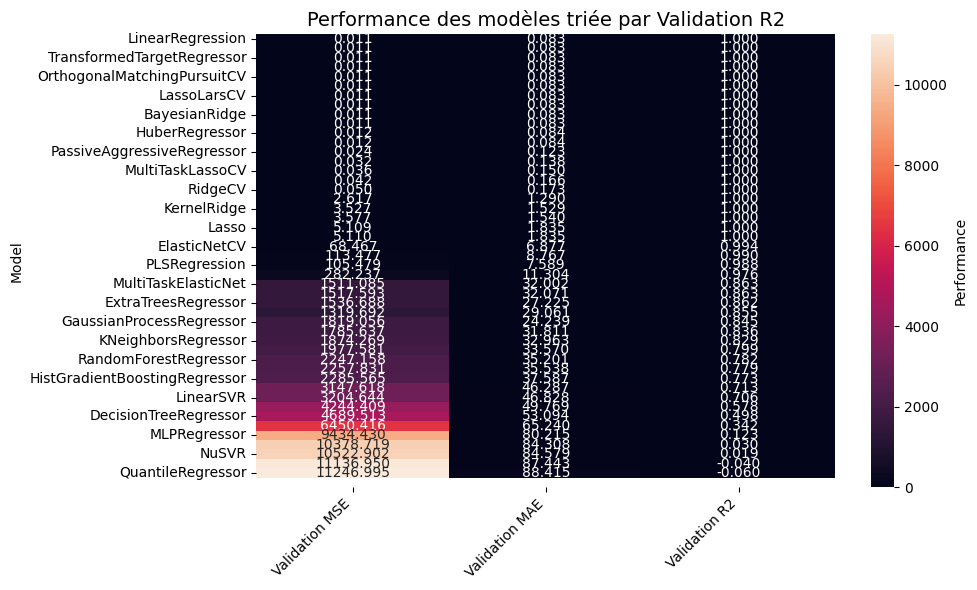

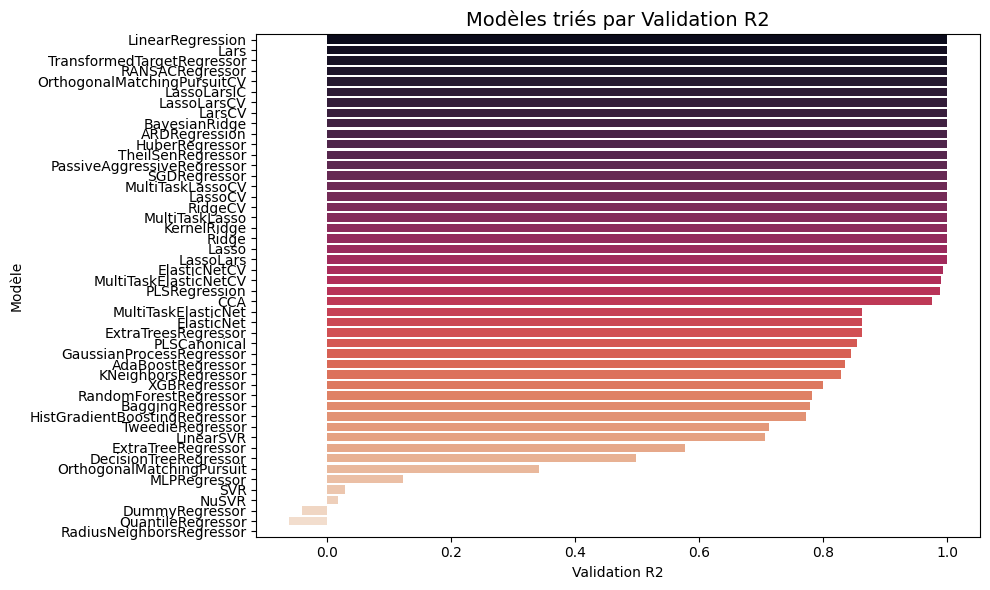

In [8]:
def plot_results_heatmap(df_results):
    plt.figure(figsize=(10, 6))
    heatmap_data = df_results[['Model', 'Validation MSE', 'Validation MAE', 'Validation R2']].set_index('Model')
    sns.heatmap(heatmap_data, annot=True, cmap='rocket', cbar_kws={'label': 'Performance'}, fmt='.3f')


    plt.title('Performance des modèles triée par Validation R2', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_results_heatmap(df_results)

def plot_results_barh(df_results, metric='Validation R2'):
    plt.figure(figsize=(10, 6))
    df_results = df_results.sort_values(by=metric, ascending=False)
    sns.barplot(x=metric, y='Model', data=df_results, palette='rocket')
    plt.title(f'Modèles triés par {metric}', fontsize=14)
    plt.xlabel(metric)
    plt.ylabel('Modèle')
    plt.tight_layout()
    plt.show()


plot_results_barh(df_results, metric='Validation R2')
